In [1]:
!pip install xgboost

from xgboost import XGBRegressor

In [2]:
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math

# Load Preprocessed Data

In [3]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')
X_train_val = pd.read_csv('X_train_val.csv')
y_train_val = pd.read_csv('y_train_val.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
X_train_scaled = pd.read_csv('X_train_scaled.csv')
y_train_scaled = pd.read_csv('y_train_scaled.csv')
X_val_scaled = pd.read_csv('X_val_scaled.csv')
X_train_val_scaled = pd.read_csv('X_train_val_scaled.csv')
y_train_val_scaled = pd.read_csv('y_train_val_scaled.csv')
X_test_scaled = pd.read_csv('X_test_scaled.csv')

In [4]:
train =  pd.read_csv('train.csv')
test =  pd.read_csv('test.csv')
train_val =  pd.read_csv('train_val.csv')
val =  pd.read_csv('val.csv')

In [5]:
feature_pool = X_train.columns

# Baseline

## Functions

In [6]:
# Evaluation Metrics
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_rmse(y_true, y_pred): 
    
    return math.sqrt(mean_squared_error(y_true, y_pred))

# Evaluation Model
def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed, \
                          n_estimators, \
                          max_depth, \
                          learning_rate, \
                          min_child_weight, \
                          subsample, \
                          colsample_bytree, \
                          colsample_bylevel, \
                          gamma):

    model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    

    model.fit(X_train_scaled, y_train_scaled)
    
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

## Model Performance before Tuning

In [7]:
# Model Parameters
n_estimators = 100                         
max_depth = 3                               
learning_rate = 0.1                         
min_child_weight = 1                  
subsample = 1                  
colsample_bytree = 1           
colsample_bylevel = 1          
gamma = 0                      
model_seed = 100

In [8]:
#Using the default parameters, test on train scaled and evaluate on validation scaled 

rmse_bef_tuning, mape_bef_tuning, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed = model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)


print("RMSE on val set = ",  round(rmse_bef_tuning, 3) ) 
print("MAPE on val set = ",  round(mape_bef_tuning, 3) ) 

RMSE on val set =  3013.45
MAPE on val set =  19.171


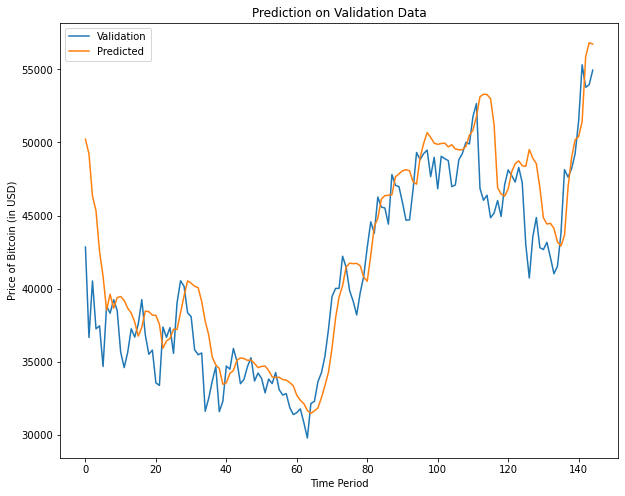

In [9]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

plt.plot(val['Close'], label = 'Validation') 
plt.plot(pred, label='Predicted')
plt.title("Prediction on Validation Data")
plt.xlabel("Time Period")
plt.ylabel("Price of Bitcoin (in USD)")
plt.legend()

In [10]:
#imp = list(zip(train[feature_pool], pred.feature_importances_))
#imp.sort(key=lambda tup: tup[1]) 
#imp[-10:]

# XGBoost : Hyperparameter Tuning

## No of Estimators, Max Depth 

In [11]:
param_label = 'n_estimators'
param_list = range(10, 500, 5)

param2_label = 'max_depth'
param2_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in param_list:    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate   

,n_estimators,max_depth,rmse,mape_pct
0,10,1,2907.023056,18.839749
1,10,2,2833.227425,18.717309
2,10,3,2811.661135,18.699543
3,10,4,2820.654098,18.696875
4,10,5,2812.277697,18.702436
...,...,...,...,...
975,495,6,3020.599345,19.188460
976,495,7,3005.693452,19.190362
977,495,8,2983.016801,19.156405
978,495,9,2993.900291,19.186428


In [12]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = ", round(error_rate['rmse'].min(), 3) ) 
print("optimum params = ", n_estimators_opt, max_depth_opt)

min RMSE =  2808.839
optimum params =  10 7


In [13]:
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ",  round(error_rate['mape_pct'].min(), 2))
print("optimum params = ", temp['n_estimators'].values[0], temp['max_depth'].values[0])

min MAPE =  18.7
optimum params =  10 4


## Learning Rate, Min Child Weights 

In [14]:
param_label = 'learning_rate'
param_list = list(np.arange(0.001, 1, 0.005)) 

param2_label = 'min_child_weight'
param2_list = range(1, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in (param_list):
    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                    y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate   

,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,1,2610.776308,17.975476
1,0.001,2,2610.776308,17.975476
2,0.001,3,2610.776820,17.975474
3,0.001,4,2610.789345,17.975405
4,0.001,5,2610.822239,17.975223
...,...,...,...,...
3995,0.996,16,2969.721640,19.161182
3996,0.996,17,3095.256728,19.319823
3997,0.996,18,2936.991463,19.083311
3998,0.996,19,3072.751067,19.313434


In [15]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = ", error_rate['rmse'].min())
print("optimum params = ",
learning_rate_opt, min_child_weight_opt)

min RMSE =  2610.280674803077
optimum params =  0.001 20


In [16]:
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ", round(error_rate['mape_pct'].min(), 3))
print("optimum params = ", 
temp['learning_rate'].values[0], temp['min_child_weight'].values[0])

min MAPE =  17.975
optimum params =  0.001 20


## Subsample, gamma

In [17]:
param_label = 'subsample'
param_list = list(np.arange(0.1, 1, 0.1))  

param2_label = 'gamma'
param2_list = list(np.arange(0.01, 1, 0.01))  

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in (param_list):
    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate   

,subsample,gamma,rmse,mape_pct
0,0.1,0.01,2609.688764,17.966354
1,0.1,0.02,2609.688764,17.966354
2,0.1,0.03,2609.688764,17.966354
3,0.1,0.04,2609.688764,17.966354
4,0.1,0.05,2609.688764,17.966354
...,...,...,...,...
886,0.9,0.95,2610.423304,17.974567
887,0.9,0.96,2610.423304,17.974567
888,0.9,0.97,2610.423304,17.974567
889,0.9,0.98,2610.423304,17.974567


In [18]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = ", round(error_rate['rmse'].min(), 3))
print("optimum params = ",
subsample_opt, gamma_opt)

min RMSE =  2609.689
optimum params =  0.1 0.01


In [19]:
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ", round(error_rate['mape_pct'].min(), 3))
print("optimum params = ",
temp['subsample'].values[0], temp['gamma'].values[0])

min MAPE =  17.966
optimum params =  0.1 0.01


## colsample_bytree, colsample_bylevel

In [20]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in (param_list):    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate   

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,2609.630393,17.966330
1,0.5,0.6,2609.664964,17.966310
2,0.5,0.7,2609.672294,17.966324
3,0.5,0.8,2609.683274,17.966344
4,0.5,0.9,2609.683274,17.966344
5,0.5,1.0,2609.684420,17.966346
6,0.6,0.5,2609.682972,17.966343
7,0.6,0.6,2609.682972,17.966343
8,0.6,0.7,2609.684541,17.966346
9,0.6,0.8,2609.685928,17.966349


In [21]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = ", round(error_rate['rmse'].min(), 3))
print("optimum params = ",
colsample_bytree_opt, colsample_bylevel_opt)

min RMSE =  2609.63
optimum params =  0.5 0.5


In [22]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ", round(error_rate['mape_pct'].min(), 3))
print("optimum params = ",
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0])

min MAPE =  17.966
optimum params =  0.8 0.7


## Tuned parameters

In [23]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params
tuned_params

,param,original,after_tuning
0,n_estimators,100.000000,10.000000
1,max_depth,3.000000,7.000000
2,learning_rate,0.100000,0.001000
3,min_child_weight,1.000000,20.000000
4,subsample,1.000000,0.100000
5,colsample_bytree,1.000000,0.500000
6,colsample_bylevel,1.000000,0.500000
7,gamma,0.000000,0.010000
8,rmse,3013.450322,2609.630393
9,mape_pct,19.170685,17.965597


In [24]:
rmse, mape, pred = train_pred_eval_model(X_train_val_scaled, 
                             y_train_val_scaled, 
                             X_test_scaled, 
                             y_test, 
                             test['Close_mean'],
                             test['Close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 2563.519
MAPE on test set = 21.804%


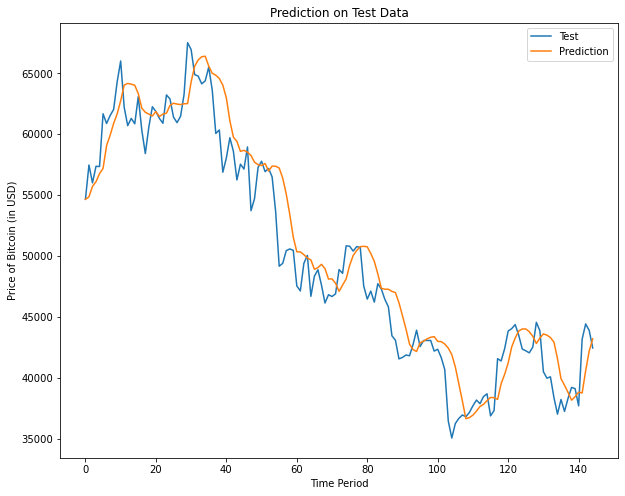

In [25]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

plt.plot(y_test['Close'], label = 'Test') 
plt.plot(pred, label='Prediction')
plt.title("Prediction on Test Data")
plt.xlabel("Time Period")
plt.ylabel("Price of Bitcoin (in USD)")
plt.legend()

# Prediction 

In [28]:
test_scaled = test[feature_pool]
test_scaled

,Compound_lag_1,Close_lag_1,Volume_lag_1,FundingRate_lag_1,Bitcoin_SVI_lag_1,Cryptocurrency_SVI_lag_1,No. of Active Addresses_lag_1,No. of Unique Addresses_lag_1,Transactions_lag_1,Compound_lag_2,...,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5,Close_mean,Close_std
0,0.161596,54947.7,303944142.6,0.010000,13.58,34.42,991926.0,620238.0,246189.0,0.161596,...,51462.3,433273705.8,0.006667,15.61,33.58,1037679.0,729159.0,312538.0,53890.60,1504.842095
1,0.161596,54663.6,415682780.3,0.016667,13.32,25.40,803826.0,536877.0,211506.0,0.161596,...,55314.7,609030484.6,0.006667,20.03,41.13,914612.0,657752.0,267749.0,54530.86,653.724463
2,0.161596,57471.9,482625180.7,0.010000,17.08,30.08,1009017.0,676676.0,280184.0,0.161596,...,53778.6,583950349.0,0.016667,16.97,42.81,1144142.0,784172.0,325875.0,54962.30,1484.421727
3,0.335250,56004.5,529269410.6,0.010000,16.39,28.74,937369.0,673664.0,274155.0,0.161596,...,53949.7,417615286.1,0.026667,15.61,36.09,978503.0,689788.0,280028.0,55407.48,1370.049310
4,0.161596,57367.2,470511860.3,0.010000,15.03,26.07,975651.0,677323.0,288916.0,0.335250,...,54947.7,303944142.6,0.010000,13.58,34.42,991926.0,620238.0,246189.0,56090.98,1312.217508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.131040,39119.1,306410979.9,0.006667,14.37,16.17,818914.0,582374.0,220423.0,0.136800,...,38229.6,324319840.5,-0.003333,16.98,22.86,886571.0,647191.0,260265.0,38427.46,798.004588
141,0.106867,37706.7,388368905.7,0.006667,12.96,21.07,768705.0,583361.0,211164.0,0.131040,...,37248.1,331098529.4,-0.003333,14.37,20.07,859810.0,622682.0,251275.0,38322.88,862.105969
142,0.135383,43179.8,564121052.5,-0.010000,16.20,24.83,981066.0,702483.0,270918.0,0.106867,...,38320.9,680985023.6,-0.003333,27.43,23.42,958866.0,676575.0,254139.0,39509.22,2143.036028
143,0.006329,44428.2,444858241.2,0.003333,17.67,29.34,1065354.0,722863.0,280634.0,0.135383,...,39219.6,386047125.7,0.003333,18.61,19.52,936543.0,687447.0,260340.0,40730.68,2902.363297


In [29]:
row = test_scaled[-5:].mean()
row = pd.DataFrame(row)
row = row.T
row

,Compound_lag_1,Close_lag_1,Volume_lag_1,FundingRate_lag_1,Bitcoin_SVI_lag_1,Cryptocurrency_SVI_lag_1,No. of Active Addresses_lag_1,No. of Unique Addresses_lag_1,Transactions_lag_1,Compound_lag_2,...,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5,Close_mean,Close_std
0,0.089611,41666.14,4.088439e+08,0.002,15.362,23.548,945167.0,664536.8,254359.2,0.103284,...,38427.46,4.057723e+08,-1.734723e-19,18.352,20.408,892140.8,643253.8,249288.4,39731.276,1949.879523


In [30]:
close_mean = test['Close_mean'][-5:].mean()
close_std = test['Close_std'][-5:].mean()

In [31]:
model = XGBRegressor(seed=model_seed,
                     n_estimators=10,
                     max_depth=2,
                     learning_rate=0.016,
                     min_child_weight=1,
                     subsample=0.6,
                     colsample_bytree=0.5,
                     colsample_bylevel=0.6,
                     gamma=0.1)
model.fit(X_train_val_scaled,y_train_val_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.016, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [34]:
est_scaled = model.predict(row)
est = est_scaled * close_std + close_mean
est[0]

40999.617

Reality: Bitcoin's market dominance fell 0.11 percent to 43.06 percent and the currency was trading at $41,430.77 on the morning of March 4.4 Mar 2022
